In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from lifelines.fitters.piecewise_exponential_regression_fitter import PiecewiseExponentialRegressionFitter
from lifelines import *
from lifelines.datasets import load_regression_dataset
from lifelines.generate_datasets import piecewise_exponential_survival_data


In [2]:
# this code can be skipped
# generating piecewise exponential data to look like a monthly churn curve. 

N, d = 2000, 2

# some numbers take from http://statwonk.com/parametric-survival.html
breakpoints = (1, 31, 34, 62, 65, 93, 96)

betas = np.array(
    [
        [1.0, -0.2, np.log(15)],
        [5.0, -0.4, np.log(333)],
        [9.0, -0.6, np.log(18)],
        [5.0, -0.8, np.log(500)],
        [2.0, -1.0, np.log(20)],
        [1.0, -1.2, np.log(500)],
        [1.0, -1.4, np.log(20)],
        [1.0, -3.6, np.log(250)],
    ]
)

X = 0.1 * np.random.exponential(size=(N, d))
X = np.c_[X, np.ones(N)]

T = np.empty(N)
for i in range(N):
    lambdas = np.exp(-betas.dot(X[i, :]))
    T[i] = piecewise_exponential_survival_data(1, breakpoints, lambdas)[0]

T_censor = np.minimum(T.mean() * np.random.exponential(size=N), 110) # 110 is the end of observation, eg. current time. 

df = pd.DataFrame(X[:, :-1], columns=['var1', 'var2'])
df["T"] = np.minimum(T, T_censor)
df["E"] = T <= T_censor


In [3]:
df.head()

,var1,var2,T,E
0,0.302575,0.170184,68.502873,False
1,0.094912,0.046740,110.000000,False
2,0.112535,0.052899,52.589615,False
3,0.125926,0.016203,10.558145,True
4,0.088505,0.080449,110.000000,False


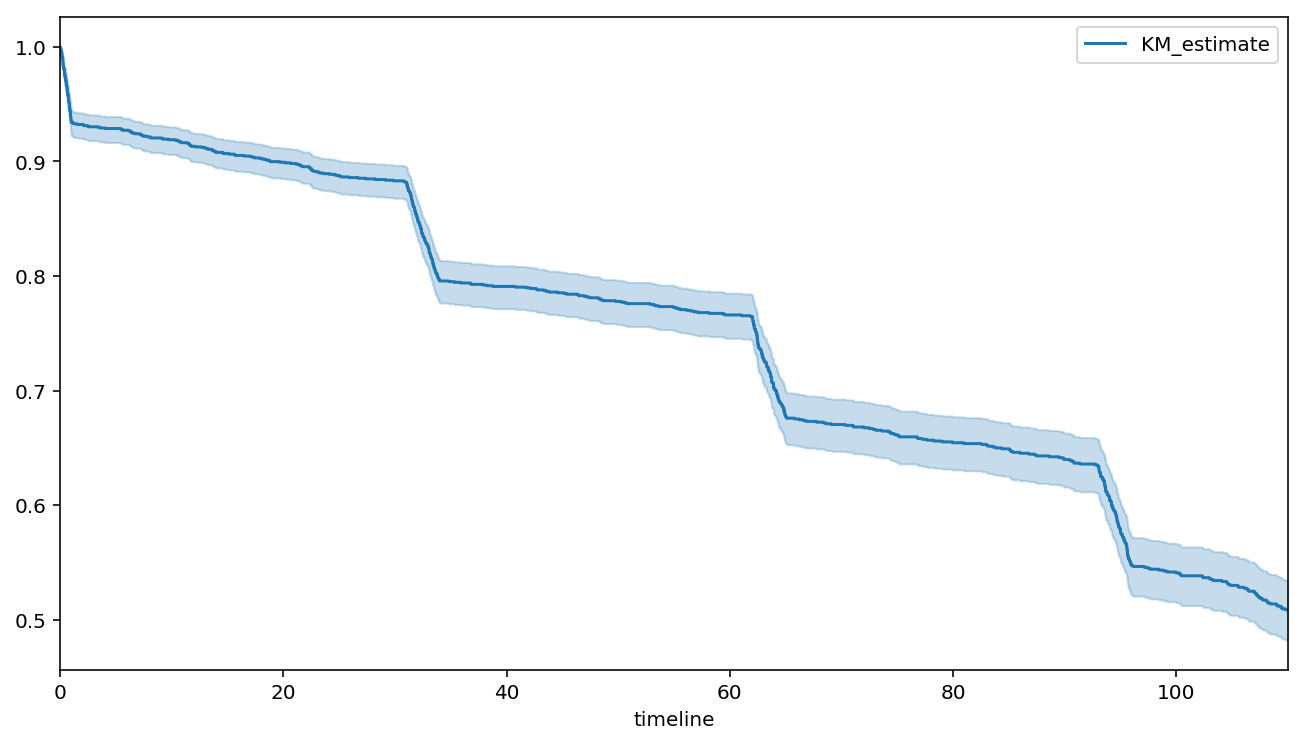

In [4]:
kmf = KaplanMeierFitter().fit(df['T'], df['E'])
kmf.plot(figsize=(11,6))

To borrow a term from finance, we clearly have different _regimes_ that a customer goes through: periods of low churn and periods of high churn, both of which are predictable. 

Let's fit a piecewise hazard model to this curve. Since we have baseline information, we can fit a regression model. For simplicity, let's assume that a customer's hazard is constant in each period, however it varies over each customer (heterogenity in customers). 

Our hazard model looks like¹:
$$
 h(t\;|\;x) = \begin{cases}
                        \lambda_0(x)^{-1},  & t \le \tau_0 \\
                        \lambda_1(x)^{-1} & \tau_0 < t \le \tau_1 \\
                        \lambda_2(x)^{-1} &  \tau_1 < t \le \tau_2 \\
                        ...
                      \end{cases}
$$

and $\lambda_i(x) = \exp(\mathbf{\beta}_i x^T), \;\; \mathbf{\beta}_i = (\beta_{i,1}, \beta_{i,2}, ...)$. That is, each period has a hazard rate, $\lambda_i$ the is the exponential of a linear model. The parameters of each linear model are unique to that period - different periods have different parameters (later we will generalize this).  

Why do I want a model like this? Well, it offers lots of flexibilty (at the cost of efficiency though), but importantly I can see:

1. Influence of variables over time.
2. Looking at important variablas at specific "drops" (or regime changes). For example, what variables cause the large drop at the start? What variables prevent death at the second billing?
3. Predictive power: since we model the hazard more accurately (we hope) than a simpler parametric form, we have better estimates of a subjects survival curve. 

¹ I specifiy the reciprocal because that follows lifelines convention for exponential and weibull hazards. In practice, it means the interpretation of the sign is possibly different. 



In [5]:
pew = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints)\
    .fit(df, "T", "E")

pew.print_summary()


<lifelines.PiecewiseExponentialRegressionFitter: fitted with 2000 observations, 1234 censored>
      duration col = 'T'
         event col = 'E'
number of subjects = 2000
  number of events = 766
    log-likelihood = -3823.68
  time fit was run = 2019-03-27 18:49:23 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda_0_ var1        0.04      1.04      0.90  0.05   0.96      0.06       -1.72        1.81
          var2       -0.76      0.47      0.88 -0.87   0.39      1.37       -2.48        0.96
          _intercept  2.76     15.86      0.15 18.13 <0.005    241.61        2.47        3.06
lambda_1_ var1        6.02    413.39      1.65  3.65 <0.005     11.87        2.79        9.26
          var2       -0.60      0.55      1.04 -0.58   0.56      0.82       -2.64        1.44
          _intercept  5.85    347.13      0.18 32.85 <0.005    783.84        5.50        6.20
lambda_2_ var1        7.03   1133.55      1.40  5.03 <0.005     20

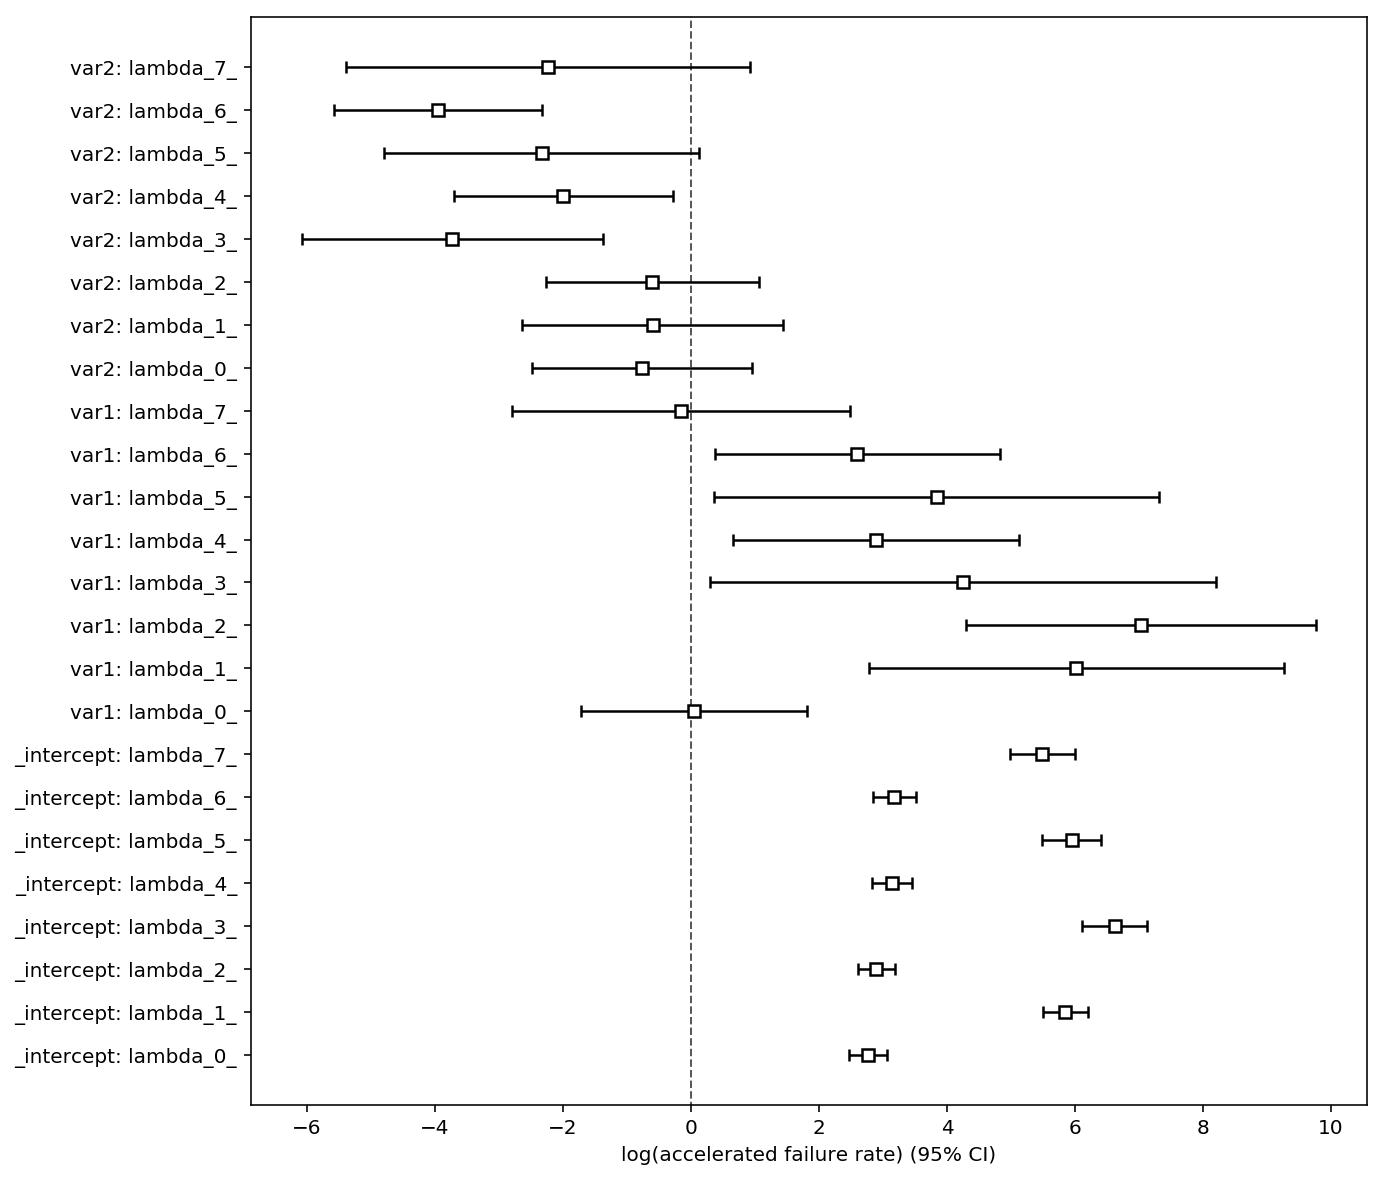

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
pew.plot(ax=ax)

If we suspect there is some parameter sharing between pieces, or we want to regularize (and hence share information)
between pieces, we can include a penalizer which penalizes the variance of the estimates per covariate.

Specifically, our penalized log-likelihood, $PLL$, looks like:

$$
PLL = LL - \alpha \sum_j \hat{\sigma}_j^2
$$

where $\hat{\sigma}_j$ is the standard deviation of $\beta_{i, j}$ over all periods $i$. This acts as a regularizer and much like a multilevel component in Bayesian statistics. 

Below we examine some cases of $\alpha$. 

Note: we do _not_ penalize the intercept, currently. This is a modellers decision, but I think it's better not too.


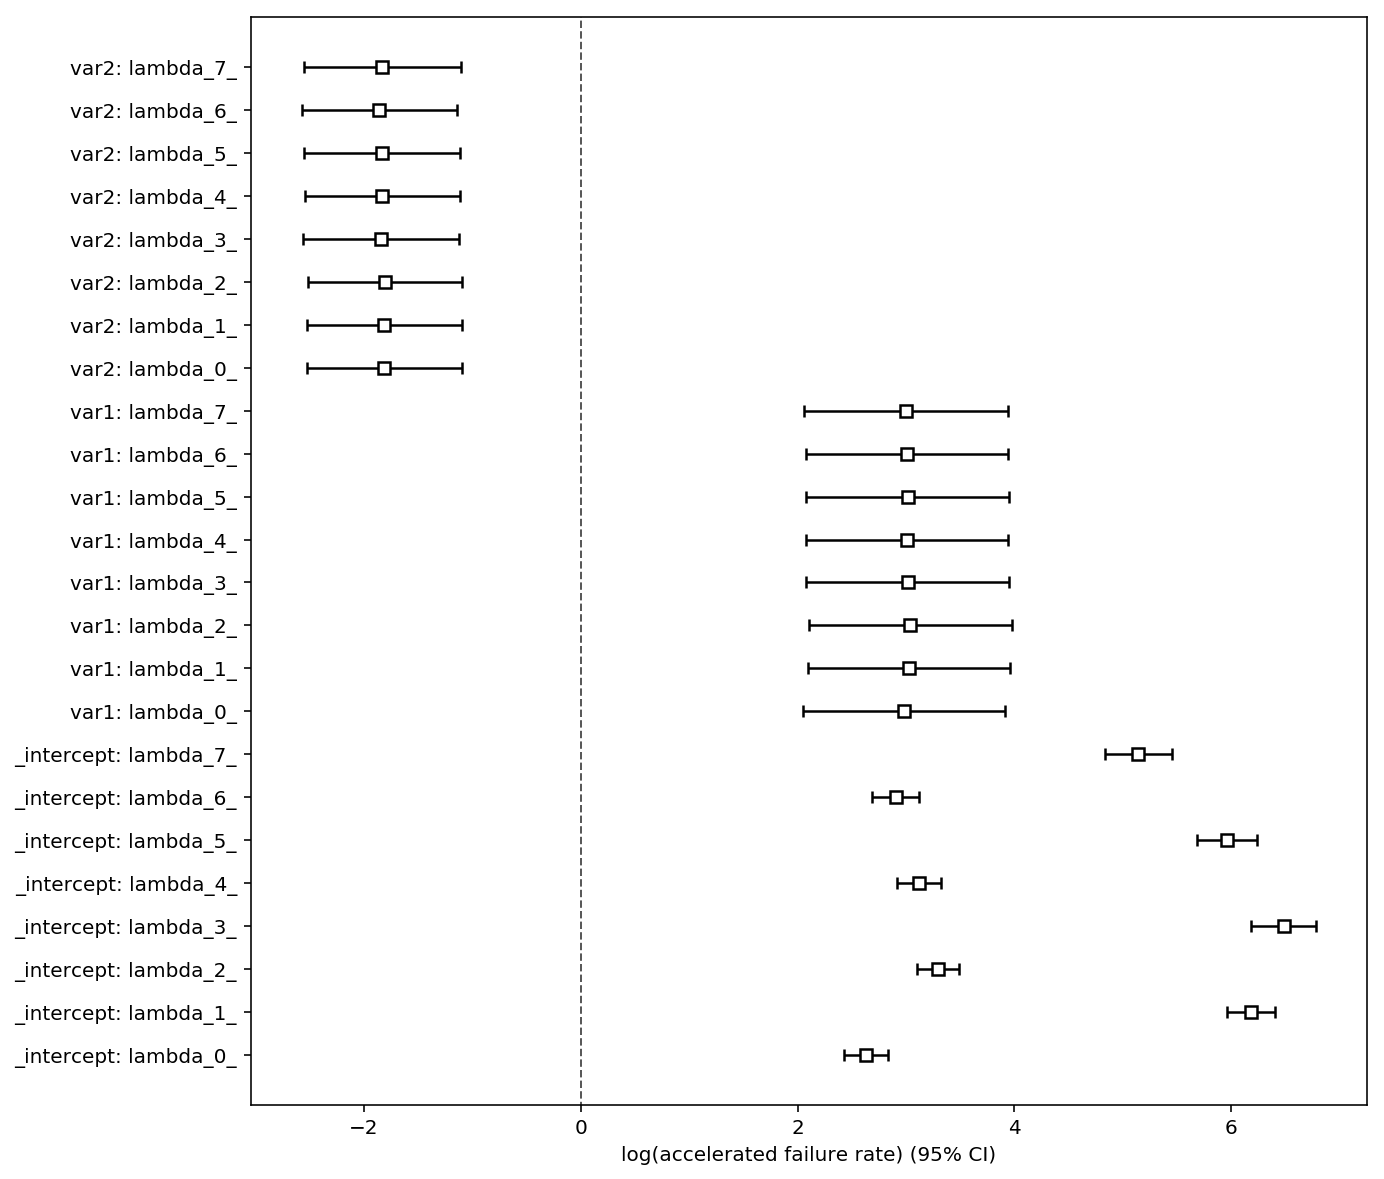

In [7]:
# Extreme case, note that all the covariates' parameters are almost identical. 
pew = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints, 
    penalizer=20.0)\
    .fit(df, "T", "E")

fig, ax = plt.subplots(figsize=(10, 10))
pew.plot(ax=ax)

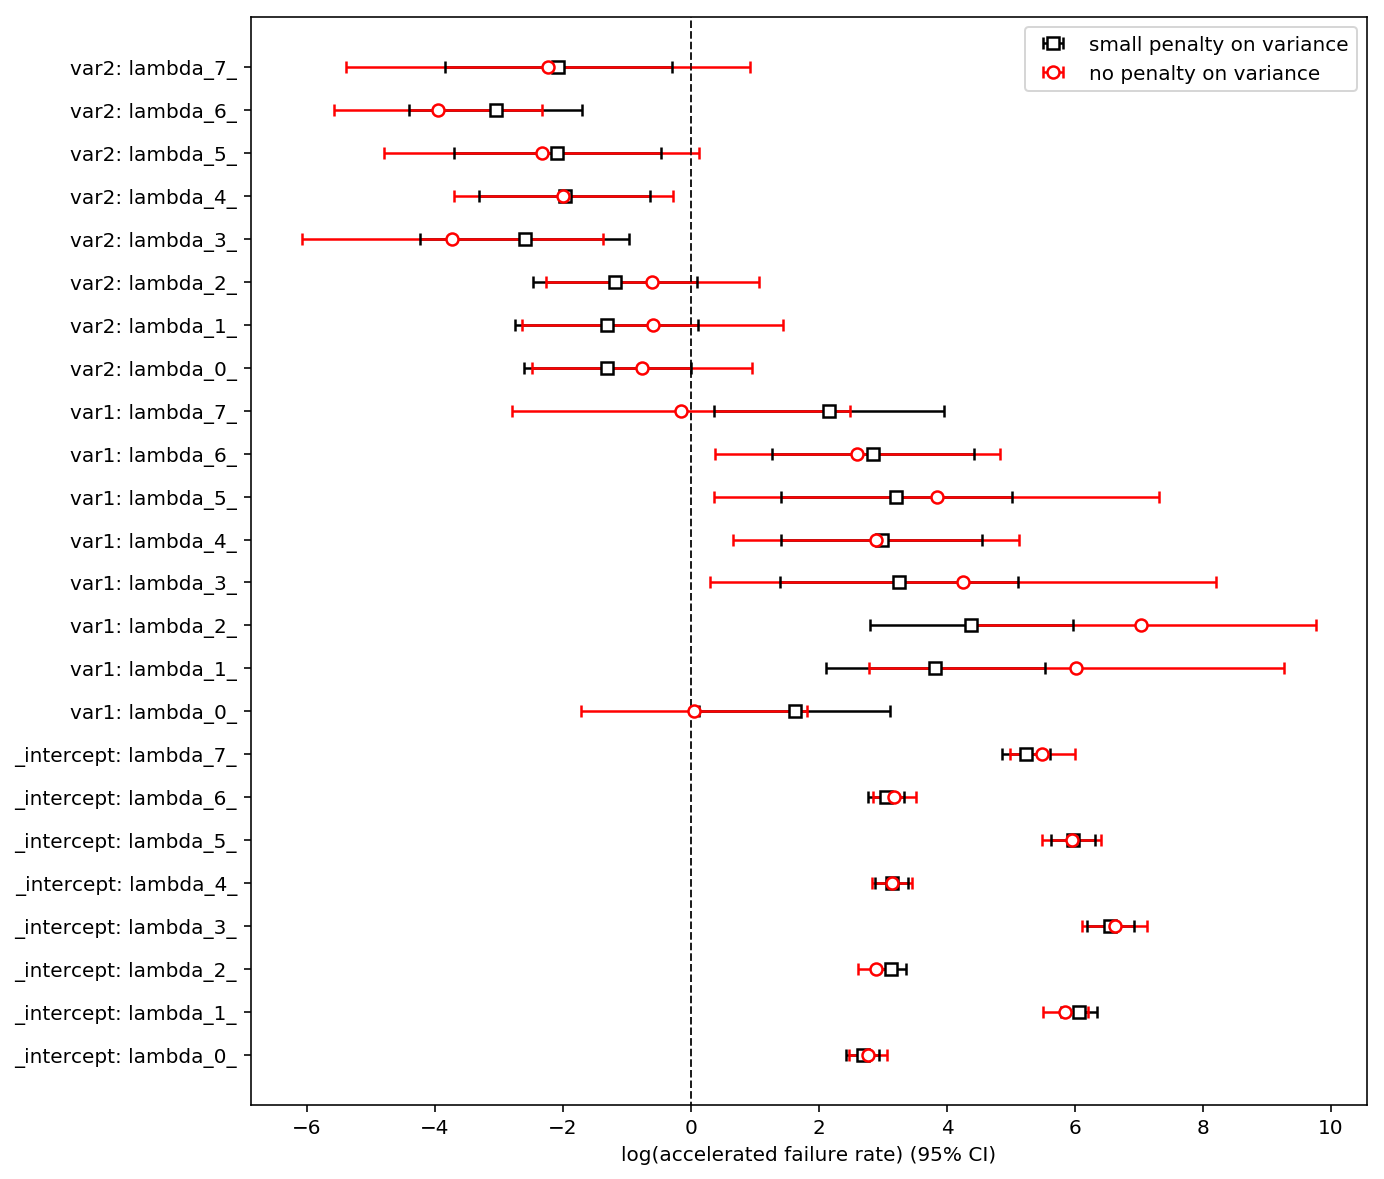

In [8]:
# less extreme case
pew = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints, 
    penalizer=.25)\
    .fit(df, "T", "E", timeline=np.linspace(0, 130, 200))

fig, ax = plt.subplots(figsize=(10, 10))
pew.plot(ax=ax, fmt="s", label="small penalty on variance")

# compare this to the no penalizer case

pew_no_penalty = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints, 
    penalizer=0)\
    .fit(df, "T", "E", timeline=np.linspace(0, 130, 200))

pew_no_penalty.plot(ax=ax, c="r", fmt="o", label="no penalty on variance")
plt.legend()

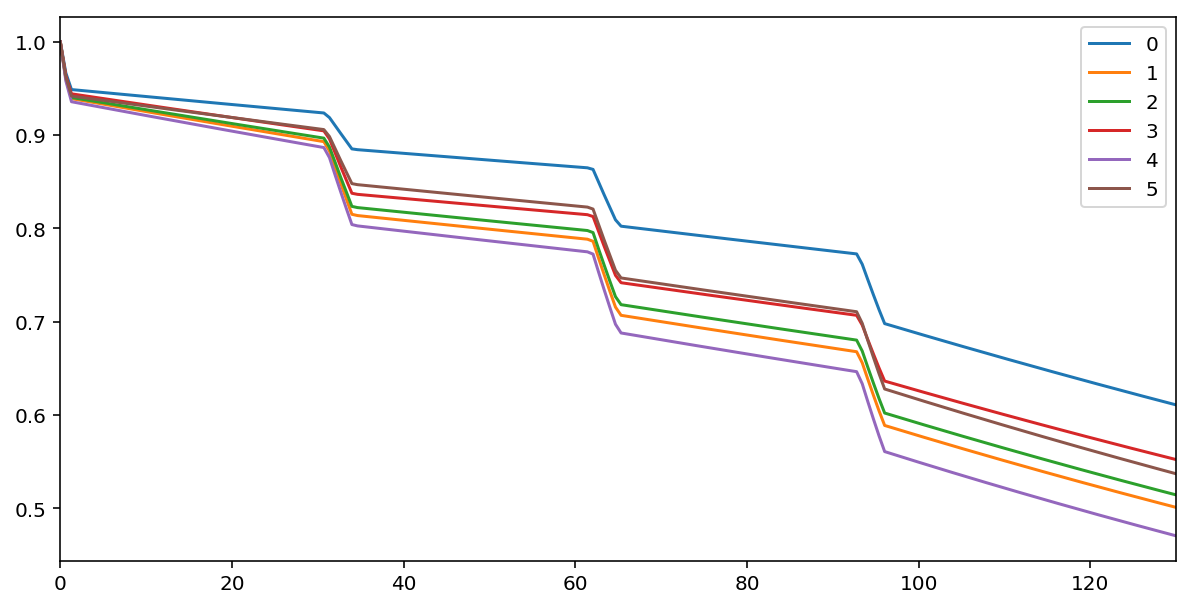

In [9]:
# Some prediction methods

pew.predict_survival_function(df.loc[0:5]).plot(figsize=(10, 5))

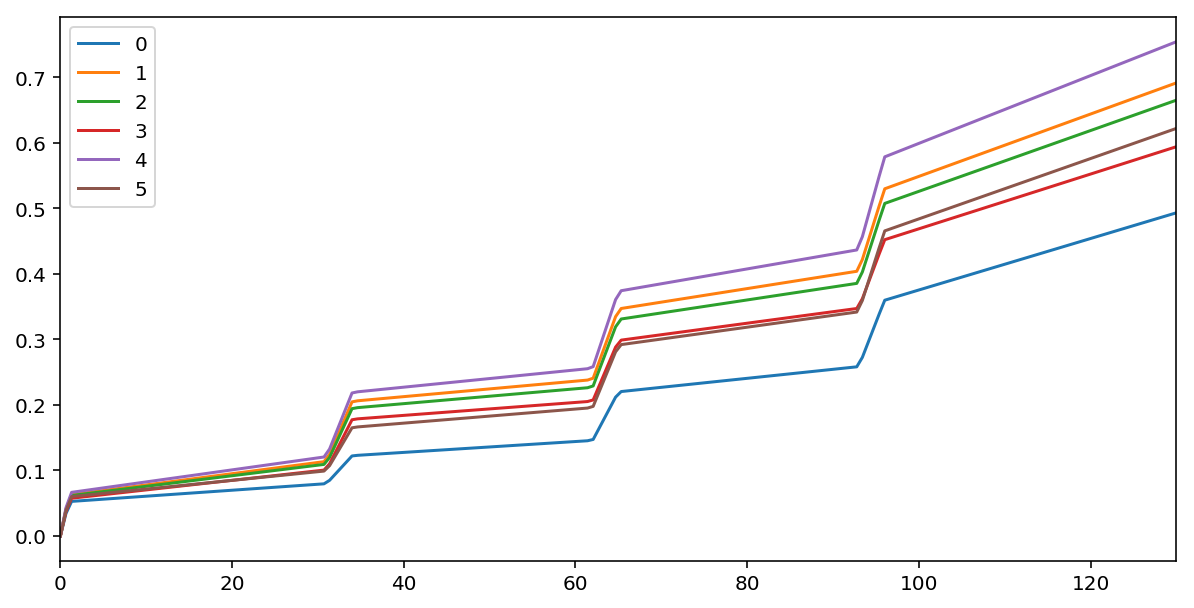

In [10]:
pew.predict_cumulative_hazard(df.loc[0:5]).plot(figsize=(10, 5))

In [11]:
pew.predict_median(df.loc[0:5])

,0.5
0,inf
1,inf
2,inf
3,inf
4,118.241206
5,inf


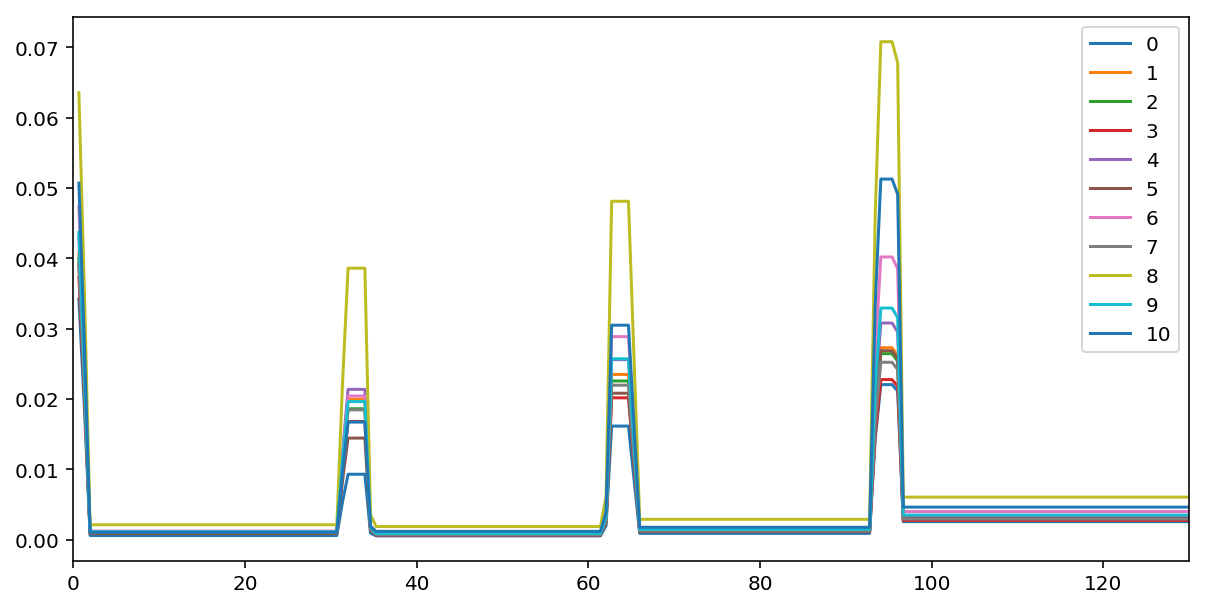

In [15]:
# hazard
pew.predict_cumulative_hazard(df.loc[0:5]).diff().plot(figsize=(10, 5))

In [13]:
pew.print_summary()

<lifelines.PiecewiseExponentialRegressionFitter: fitted with 2000 observations, 1234 censored>
      duration col = 'T'
         event col = 'E'
         penalizer = 0.25
number of subjects = 2000
  number of events = 766
    log-likelihood = -3836.07
  time fit was run = 2019-03-27 18:49:26 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda_0_ var1        1.62      5.06      0.76  2.13   0.03      4.90        0.13        3.12
          var2       -1.31      0.27      0.67 -1.96   0.05      4.31       -2.62        0.00
          _intercept  2.68     14.60      0.13 20.62 <0.005    311.43        2.43        2.94
lambda_1_ var1        3.82     45.57      0.87  4.37 <0.005     16.29        2.11        5.53
          var2       -1.32      0.27      0.73 -1.81   0.07      3.82       -2.75        0.11
          _intercept  6.07    432.40      0.14 42.63 <0.005       inf        5.79        6.35
lambda_2_ var1        4.38     80.10    

In [14]:
from lifelines import WeibullAFTFitter
wf = WeibullAFTFitter().fit(df, 'T', 'E')